In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
import sys
sys.path.append('../')

In [2]:
import argparse
import json
import os
import sys
from pathlib import Path

import numpy as np
import torch

# from models.common import DetectMultiBackend
# from utils.callbacks import Callbacks
# from utils.dataloaders import create_dataloader
# from utils.general import (LOGGER, Profile, check_dataset, check_img_size, check_requirements, check_yaml,
#                            coco80_to_coco91_class, colorstr, increment_path, non_max_suppression, print_args,
#                            scale_boxes, xywh2xyxy, xyxy2xywh)
# from utils.metrics import ConfusionMatrix, ap_per_class, box_iou
# from utils.plots import output_to_target, plot_images, plot_val_study
# from utils.torch_utils import select_device, smart_inference_mode

/Users/louislacombe/opt/anaconda3/envs/yolov5_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ROOT = "/Users/louislacombe/Thesis_code/yolov5/"
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative


LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))

In [4]:
import yaml
import datetime
from tqdm import tqdm

from utils.general import split_dict

from utils.calibration_utils import (
    setup_data_model, get_yolo_predictions, get_data_pred, calib_prep, collect_data_obj, 
    fitting_obj_calibrators, predict_obj_conf, draw_reliability_graph, 
    create_pred_for_nms, NMS, 
    collect_data_class, fitting_class_calibrators, predict_class_conf,
    )

from sklearn.isotonic import IsotonicRegression
from sklearn.base import clone

from models.common import DetectMultiBackend
from utils.general import (check_dataset, xywh2xyxy, Profile, check_img_size, colorstr, scale_boxes, non_max_suppression, increment_path)
from utils.torch_utils import select_device
from utils.dataloaders import create_dataloader

ModuleNotFoundError: No module named 'utils'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(np.random.rand(200), np.random.rand(200))
plt.show()

In [8]:
opt = '../config/opt/opt_Visdrone_detect_S_Hyp0.yaml'
dataloader, model, opt, device, dt = setup_data_model(opt, ROOT)

YOLOv5 🚀 v6.2-197-g124a787 Python-3.10.6 torch-1.12.1 CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/Users/louislacombe/Thesis_code/datasets/VisDrone/VisDrone2019-DET-test-dev/labels.cache' images and labels... 1610 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]


In [9]:
data_dict = get_yolo_predictions(dataloader, model, opt, device, dt)

                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 51/51 [11:06<00:00, 13.07s/it]


In [10]:
calib_dict, test_dict = split_dict(data_dict, (0.3, 0.7))
print("Length calib dict: ", len(calib_dict), " and length calib dict: ", len(test_dict))

Length calib dict:  16  and length calib dict:  35


# Calibration

In [11]:
# Calibration parameters:
n_bins = 50
conf_thres = opt.conf_thres
iou_thres_obj = 0.6
iou_thres_class = 0.3
num_classes = model.model.nc

where_apply_calib_obj = "pred"
where_apply_calib_class = "after_mns"

# Choose which calibrator you want to use for the calibration
# calibrator = HistogramBinning(n_bins) # Histogram binning
# calibrator = _SigmoidCalibration() # Platt
calibrator = IsotonicRegression(out_of_bounds="clip") # Isotonic Regression


In [12]:
where_apply_calib="pred"

print("Calibration preperation")
calib_prep(
    calib_dict,
    where_apply_calib=where_apply_calib,
    num_classes=num_classes,
    device=device,
    conf_thres=conf_thres,
    iou_thres_obj=iou_thres_obj,
    iou_thres_class=iou_thres_class,
    obj_calib=True,
    class_calib=False
)

calib_prep(
    test_dict,
    where_apply_calib=where_apply_calib,
    num_classes=num_classes,
    device=device,
    conf_thres=conf_thres,
    iou_thres_obj=iou_thres_obj,
    iou_thres_class=iou_thres_class,
    obj_calib=True,
    class_calib=False
)

print("Putting all values together")
obj_y_pred_CALIB, obj_y_true_CALIB = collect_data_obj(calib_dict, where_apply_calib=where_apply_calib)
    
print("Calibrate")
fitted_calibrator = fitting_obj_calibrators(obj_y_true_CALIB, obj_y_pred_CALIB, calibrator)

print("Predicting the objectness values")
pred_obj_calib = predict_obj_conf(test_dict, fitted_calibrator, where_apply_calib=where_apply_calib)

print("Applying NMS with the calibrated objectness values")
name_preds = ["pred_bbox_xywh_idx", "pred_calib_obj_score", "pred_class_score_idx"]
NMS(dataloader, test_dict, name_preds=name_preds, save_after_nms="after_nms_calib", num_classes=num_classes, opt=opt, device=device)

print("Running NMS on the calibrated objects to use as train set for classes")
pred_obj_calib = predict_obj_conf(calib_dict, fitted_calibrator, where_apply_calib=where_apply_calib)
NMS(dataloader, calib_dict, name_preds=name_preds, save_after_nms="after_nms_calib", num_classes=num_classes, opt=opt, device=device)


where_apply_calib = "after_nms"

calib_prep(
    calib_dict,
    where_apply_calib=where_apply_calib,
    num_classes=num_classes,
    device=device,
    conf_thres=conf_thres,
    iou_thres_obj=iou_thres_obj,
    iou_thres_class=iou_thres_class,
    obj_calib=False,
    class_calib=True
)

calib_prep(
    test_dict,
    where_apply_calib=where_apply_calib,
    num_classes=num_classes,
    device=device,
    conf_thres=conf_thres,
    iou_thres_obj=iou_thres_obj,
    iou_thres_class=iou_thres_class,
    obj_calib=False,
    class_calib=True
)


list_y_true_calib, list_y_pred_calib = collect_data_class(calib_dict, num_classes=num_classes, where_apply_calib=where_apply_calib)
calibrators_fitted = fitting_class_calibrators(list_y_true_calib, list_y_pred_calib, calibrator, num_classes=num_classes, perc=0.6)
list_y_calibrated = predict_class_conf(test_dict, calibrators_fitted, num_classes, where_apply_calib)


Calibration preperation


100%|██████████| 35/35 [00:00<00:00, 47.51it/s]


Putting all values together
Calibrate
Predicting the objectness values
Applying NMS with the calibrated objectness values


100%|██████████| 51/51 [00:09<00:00,  5.55it/s]


Running NMS on the calibrated objects to use as train set for classes


100%|██████████| 35/35 [00:00<00:00, 285.27it/s]


In [15]:
obj_true = []
obj_normal = []
obj_calib = []

for path in test_dict:
    values_ = test_dict[path]
    if "idx" in values_.keys():
        obj_true.extend(values_["pred_obj_y_true"])
        obj_calib.extend(values_["pred_calib_obj_score"])
        obj_normal.extend(values_["pred_obj_score_idx"])


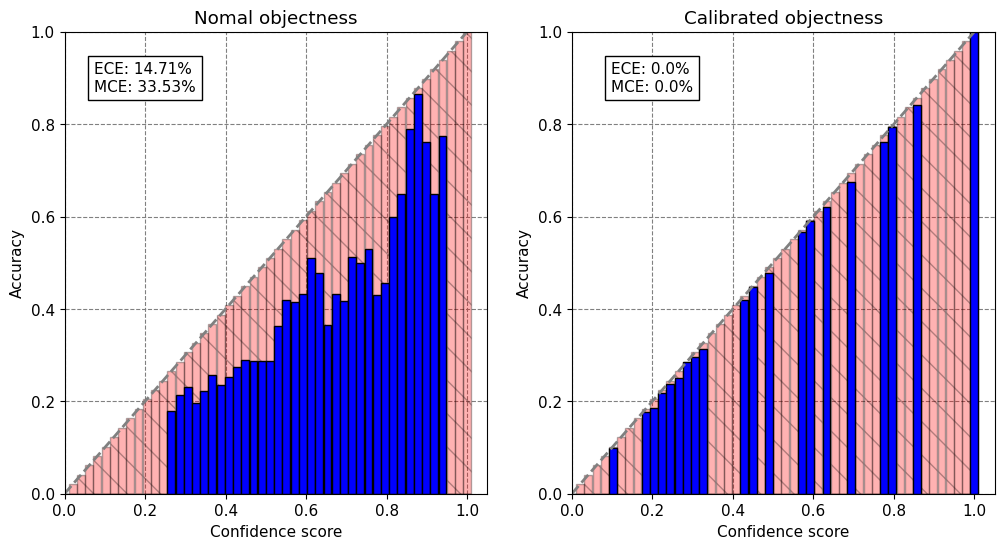

In [16]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))
draw_reliability_graph(np.array(obj_normal), np.array(obj_true), n_bins, strategy="uniform", title="Nomal objectness", axs=axs1)
draw_reliability_graph(np.array(obj_calib), np.array(obj_true), n_bins, strategy="uniform", title="Calibrated objectness", axs=axs2)
plt.show()

In [ ]:
# Configure
model.eval()
iouv = torch.linspace(0.5, 0.95, 10, device=device)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()

seen = 0
confusion_matrix = ConfusionMatrix(nc=nc)
if isinstance(names, (list, tuple)):  # old format
    names = dict(enumerate(names))
class_map = list(range(1000))
s = ('%22s' + '%11s' * 6) % ('Class', 'Images', 'Instances', 'P', 'R', 'mAP50', 'mAP50-95')
tp, fp, p, r, f1, mp, mr, map50, ap50, map = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
jdict, stats, ap, ap_class = [], [], [], []
